In [10]:
# ==========================================
# 1. INSTALLATION & IMPORTATIONS
# ==========================================
print("Installation et importation des bibliothèques")
!pip install -q transformers datasets gensim scikit-learn matplotlib seaborn torch tqdm

import os, re, random, requests, shutil, copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm # Pour les barres de chargement
import warnings
warnings.filterwarnings('ignore')

Installation et importation des bibliothèques


In [11]:
# ==========================================
# 2. CONFIGURATION DU PROJET
# ==========================================
class ProjectConfig:
    SEED = 42
    MAX_LEN = 128
    BATCH_SIZE = 64
    EPOCHS = 5
    LEARNING_RATE = 2e-5
    WEIGHT_DECAY = 0.1
    PATIENCE = 3
    MODEL_NAME = 'roberta-base'
    OUTPUT_DIR = './meilleur_modele_fake_news'
    ZIP_NAME = 'mon_modele_fake_news'
    FILES = {
        "politifact_fake": "https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/politifact_fake.csv",
        "politifact_real": "https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/politifact_real.csv",
        "gossipcop_fake": "https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_fake.csv",
        "gossipcop_real": "https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_real.csv"
    }

def set_seed(seed_val):
    random.seed(seed_val); np.random.seed(seed_val)
    torch.manual_seed(seed_val); torch.cuda.manual_seed_all(seed_val)

set_seed(ProjectConfig.SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Configuration terminée. Utilisation de {torch.cuda.device_count()} GPU(s).")

✓ Configuration terminée. Utilisation de 2 GPU(s).


In [12]:
# ==========================================
# 3. OUTILS PÉDAGOGIQUES (NOUVEAU)
# ==========================================
class Pedagogie:
    """Classe dédiée à l'explication et à la transparence du modèle."""
    
    @staticmethod
    def expliquer_tokenization(texte, tokenizer):
        """Montre à l'utilisateur comment l'IA 'lit' le texte."""
        print(f"\n🔍 [DÉMO TECHNIQUE] Vision de l'IA pour : '{texte}'")
        tokens = tokenizer.tokenize(texte)
        ids = tokenizer.convert_tokens_to_ids(tokens)
        print(f"   1. Découpage (Tokens) : {tokens}")
        print(f"   2. Numérisation (IDs) : {ids}")
        print("   -> L'IA ne comprend que ces nombres, pas les mots.\n")

    @staticmethod
    def analyser_erreurs(model, loader, tokenizer, device, dataset_name, num_exemples=3):
        """Affiche les erreurs concrètes pour comprendre les faiblesses."""
        model.eval()
        erreurs = []
        print(f"\n🕵️ [ANALYSE D'ERREURS] Où {dataset_name} s'est-il trompé ?")
        
        with torch.no_grad():
            for batch, labels in loader:
                input_ids = batch['input_ids'].to(device)
                outputs = model(input_ids, attention_mask=batch['attention_mask'].to(device))
                preds = torch.argmax(outputs.logits, dim=1)
                
                # Trouver les indices où Prédiction != Réalité
                idx_erreurs = (preds != labels.to(device)).nonzero(as_tuple=True)[0]
                
                for idx in idx_erreurs:
                    if len(erreurs) >= num_exemples: break
                    texte = tokenizer.decode(input_ids[idx], skip_special_tokens=True)
                    vrai = "Faux" if labels[idx] == 1 else "Vrai"
                    pred = "Faux" if preds[idx] == 1 else "Vrai"
                    erreurs.append(f"   🔴 Texte : \"{texte[:80]}...\"\n      Réalité : {vrai} | IA a pensé : {pred}")
                if len(erreurs) >= num_exemples: break
        
        for e in erreurs: print(e + "\n")

    @staticmethod
    def visualiser_distribution(df, nom_dataset):
        """Affiche graphiquement la balance des données."""
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        sns.countplot(x='label', data=df, palette=['green', 'red'])
        plt.title(f'Distribution : {nom_dataset.upper()}')
        plt.xticks([0, 1], ['Vrai (Real)', 'Faux (Fake)'])
        plt.ylabel("Nombre d'articles")
        
        plt.subplot(1, 2, 2)
        # Estimation rapide de la longueur
        df['len'] = df['title'].astype(str).apply(lambda x: len(x.split()))
        sns.histplot(data=df, x='len', hue='label', kde=True, palette=['green', 'red'])
        plt.title('Longueur des titres (mots)')
        plt.tight_layout()
        plt.show()

In [13]:
# ==========================================
# 4. VISUALISATION DES RÉSULTATS
# ==========================================
class Visualizer:
    @staticmethod
    def plot_history(history, dataset_name):
        epochs = range(1, len(history['train_loss']) + 1)
        plt.figure(figsize=(14, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history['train_loss'], 'b-o', label='Perte Entraînement')
        plt.title(f'{dataset_name} : Apprentissage (Loss)')
        plt.xlabel('Époques'); plt.ylabel('Perte'); plt.legend(); plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history['val_f1'], 'g-o', label='Score F1 Validation')
        plt.title(f'{dataset_name} : Performance (F1 Score)')
        plt.xlabel('Époques'); plt.ylabel('Score F1'); plt.legend(); plt.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()

    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, dataset_name):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Vrai', 'Faux'], yticklabels=['Vrai', 'Faux'])
        plt.title(f'Matrice de Confusion : {dataset_name}')
        plt.ylabel('Réel'); plt.xlabel('Prédit'); plt.show()

In [14]:
# ==========================================
# 5. GESTION DES DONNÉES
# ==========================================
class DataHandler:
    @staticmethod
    def load_csv_data(files):
        print("  -> Téléchargement des fichiers CSV...")
        dfs = []
        for name, url in files.items():
            fname = f"{name}.csv"
            if not os.path.exists(fname):
                with open(fname, 'wb') as f: f.write(requests.get(url).content)
            try: df = pd.read_csv(fname)
            except: df = pd.read_csv(fname, sep=',', on_bad_lines='skip')
            df['label'] = 1 if "fake" in name else 0
            df['dataset_source'] = 'gossipcop' if 'gossipcop' in name else 'politifact'
            dfs.append(df)
        return pd.concat(dfs, ignore_index=True)

    @staticmethod
    def afficher_statistiques(df, nom_dataset):
        """Affiche les statistiques descriptives en Français."""
        print(f"\n--- 📊 ANALYSE EXPLORATOIRE (EDA) : {nom_dataset.upper()} ---")
        
        # 1. Distribution
        dist = df['label'].value_counts()
        total = len(df)
        if total == 0: 
            print("Aucune donnée.")
            return

        print(f"1. Distribution des classes :")
        print(f"   - Vrai (Real) : {dist.get(0, 0)} ({dist.get(0, 0)/total:.1%})")
        print(f"   - Faux (Fake) : {dist.get(1, 0)} ({dist.get(1, 0)/total:.1%})")
        
        # 2. Valeurs manquantes
        nulls = df['title'].isnull().sum()
        if nulls > 0:
            print(f"⚠️ 2. Valeurs manquantes : {nulls} titres sont vides (NULL).")
        else:
            print(f"✅ 2. Valeurs manquantes : Aucune.")
            
        # 3. Doublons
        doublons = df.duplicated(subset=['title']).sum()
        if doublons > 0:
            print(f"⚠️ 3. Doublons : {doublons} articles sont identiques.")
        else:
            print(f"✅ 3. Doublons : Aucun.")
        print("-" * 50)

    @staticmethod
    def prepare(df, source):
        print(f"  -> Préparation des données pour : {source.upper()}")
        sub = df[df['dataset_source'] == source].copy()
        sub['clean_text'] = sub['title'].astype(str).str.lower()
        sub.dropna(subset=['clean_text'], inplace=True)
        sub.drop_duplicates(subset=['clean_text'], inplace=True)
        sub['label'] = sub['label'].astype(int) 
        return sub

class FastDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=max_len, return_tensors='pt')
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        return {key: val[i] for key, val in self.encodings.items()}, self.labels[i]

def get_weighted_loader(dataset, labels, batch_size):
    print("  -> Équilibrage des classes (Weighted Sampling)...")
    labels_np = np.array(labels, dtype=int)
    class_counts = np.bincount(labels_np)
    if len(class_counts) < 2: return DataLoader(dataset, batch_size=batch_size, shuffle=True)
    weights = 1. / class_counts
    samples_weights = [weights[l] for l in labels_np]
    sampler = WeightedRandomSampler(samples_weights, len(samples_weights))
    return DataLoader(dataset, batch_size=batch_size, sampler=sampler, num_workers=2)

In [15]:
# ==========================================
# 6. ENTRAÎNEUR
# ==========================================
class Trainer:
    def __init__(self, model, train_loader, val_loader):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = AdamW(model.parameters(), lr=ProjectConfig.LEARNING_RATE, weight_decay=ProjectConfig.WEIGHT_DECAY)
        self.scaler = GradScaler()
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*ProjectConfig.EPOCHS)
        self.history = {'train_loss': [], 'val_loss': [], 'val_f1': []}
        self.best_f1 = 0
        self.best_state = None

    def train(self):
        patience = 0
        print(f"\n🚀 [Démarrage] Entraînement sur {ProjectConfig.EPOCHS} époques...")
        
        for epoch in range(ProjectConfig.EPOCHS):
            self.model.train()
            total_loss = 0
            
            # Utilisation de TQDM pour la barre de chargement
            loop = tqdm(self.train_loader, leave=False, desc=f"Époque {epoch+1}/{ProjectConfig.EPOCHS}")
            
            for batch, labels in loop:
                self.model.zero_grad()
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = labels.to(device)
                with autocast():
                    outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
                    loss = outputs.loss.mean()
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.scheduler.step()
                total_loss += loss.item()
                
                # Mise à jour de la barre
                loop.set_postfix(perte=loss.item())

            avg_val_loss, val_f1, _, _ = self.evaluate()
            self.history['train_loss'].append(total_loss/len(self.train_loader))
            self.history['val_loss'].append(avg_val_loss)
            self.history['val_f1'].append(val_f1)
            
            print(f"   -> Époque {epoch+1} | Perte: {self.history['train_loss'][-1]:.4f} | F1 Val: {val_f1:.4f}")
            
            if val_f1 > self.best_f1:
                self.best_f1 = val_f1
                model_to_save = self.model.module if hasattr(self.model, 'module') else self.model
                self.best_state = copy.deepcopy(model_to_save.state_dict())
                patience = 0
            else:
                patience += 1
                if patience >= ProjectConfig.PATIENCE:
                    print(f"   🛑 Arrêt précoce (Early Stopping).")
                    break
        return self.history, self.best_f1

    def evaluate(self):
        self.model.eval()
        total_loss = 0
        preds, targets = [], []
        with torch.no_grad():
            for batch, labels in self.val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = labels.to(device)
                outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
                total_loss += outputs.loss.mean().item()
                preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
                targets.extend(labels.cpu().numpy())
        return total_loss/len(self.val_loader), f1_score(targets, preds), targets, preds


=== Phase 1 : Chargement des Données ===
  -> Téléchargement des fichiers CSV...

🔍 [DÉMO TECHNIQUE] Vision de l'IA pour : 'Fake news spreads fast.'
   1. Découpage (Tokens) : ['Fake', 'Ġnews', 'Ġspreads', 'Ġfast', '.']
   2. Numérisation (IDs) : [38193, 340, 16268, 1769, 4]
   -> L'IA ne comprend que ces nombres, pas les mots.


=== Phase 2 : Entraînement ===

DATASET : POLITIFACT

--- 📊 ANALYSE EXPLORATOIRE (EDA) : POLITIFACT ---
1. Distribution des classes :
   - Vrai (Real) : 624 (59.1%)
   - Faux (Fake) : 432 (40.9%)
✅ 2. Valeurs manquantes : Aucune.
⚠️ 3. Doublons : 73 articles sont identiques.
--------------------------------------------------


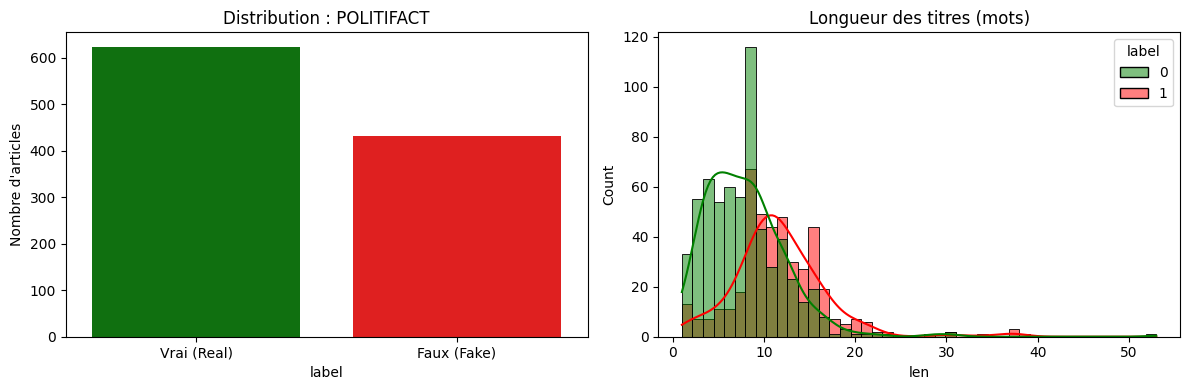

  -> Préparation des données pour : POLITIFACT
  -> Équilibrage des classes (Weighted Sampling)...


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 [Démarrage] Entraînement sur 5 époques...


Époque 1/5:   0%|          | 0/14 [00:00<?, ?it/s]

   -> Époque 1 | Perte: 0.6863 | F1 Val: 0.7516


Époque 2/5:   0%|          | 0/14 [00:00<?, ?it/s]

   -> Époque 2 | Perte: 0.5166 | F1 Val: 0.7883


Époque 3/5:   0%|          | 0/14 [00:00<?, ?it/s]

   -> Époque 3 | Perte: 0.2433 | F1 Val: 0.8346


Époque 4/5:   0%|          | 0/14 [00:00<?, ?it/s]

   -> Époque 4 | Perte: 0.2690 | F1 Val: 0.8571


Époque 5/5:   0%|          | 0/14 [00:00<?, ?it/s]

   -> Époque 5 | Perte: 0.1904 | F1 Val: 0.8480


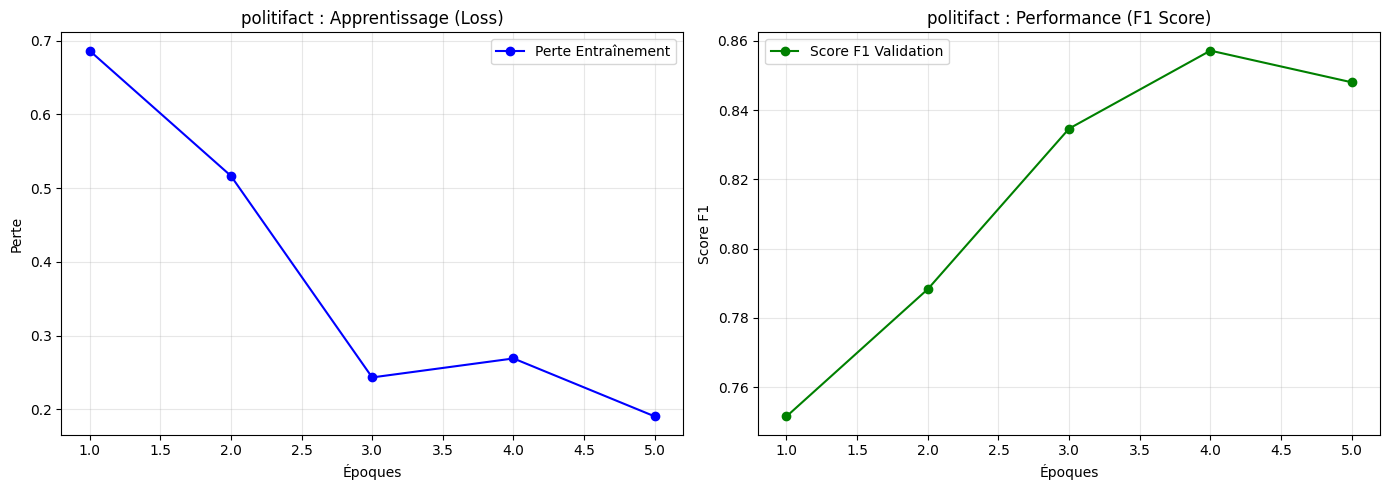


🕵️ [ANALYSE D'ERREURS] Où politifact s'est-il trompé ?
   🔴 Texte : "information for the nation..."
      Réalité : Faux | IA a pensé : Vrai

   🔴 Texte : "un refugee agency welcomes arrival of 10,000th syrian refugee resettled to unite..."
      Réalité : Vrai | IA a pensé : Faux

   🔴 Texte : "statement from fda commissioner scott gottlieb, m.d., on fda’s ongoing efforts t..."
      Réalité : Faux | IA a pensé : Vrai



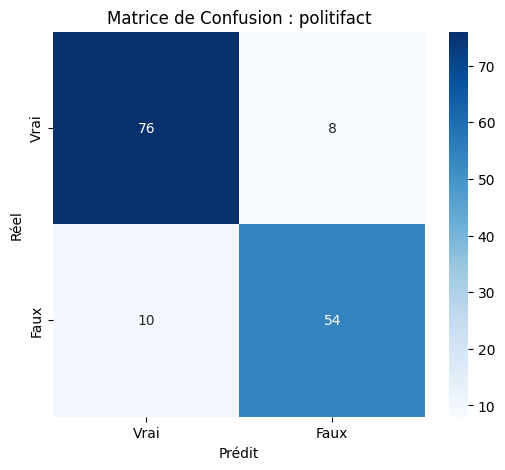


📄 [Rapport : POLITIFACT]
              precision    recall  f1-score   support

        Vrai       0.88      0.90      0.89        84
        Faux       0.87      0.84      0.86        64

    accuracy                           0.88       148
   macro avg       0.88      0.87      0.88       148
weighted avg       0.88      0.88      0.88       148


DATASET : GOSSIPCOP

--- 📊 ANALYSE EXPLORATOIRE (EDA) : GOSSIPCOP ---
1. Distribution des classes :
   - Vrai (Real) : 16817 (76.0%)
   - Faux (Fake) : 5323 (24.0%)
✅ 2. Valeurs manquantes : Aucune.
⚠️ 3. Doublons : 1397 articles sont identiques.
--------------------------------------------------


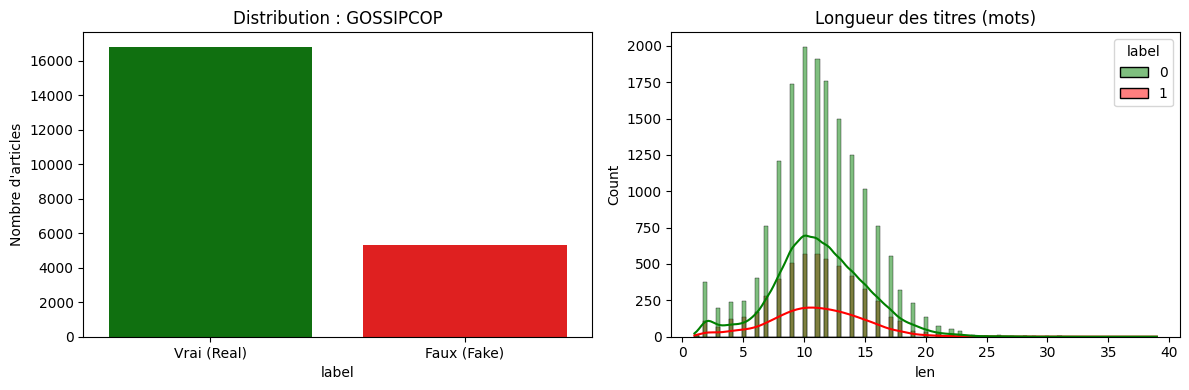

  -> Préparation des données pour : GOSSIPCOP
  -> Équilibrage des classes (Weighted Sampling)...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 [Démarrage] Entraînement sur 5 époques...


Époque 1/5:   0%|          | 0/276 [00:00<?, ?it/s]

   -> Époque 1 | Perte: 0.4858 | F1 Val: 0.6479


Époque 2/5:   0%|          | 0/276 [00:00<?, ?it/s]

   -> Époque 2 | Perte: 0.3434 | F1 Val: 0.5866


Époque 3/5:   0%|          | 0/276 [00:00<?, ?it/s]

   -> Époque 3 | Perte: 0.2694 | F1 Val: 0.6654


Époque 4/5:   0%|          | 0/276 [00:00<?, ?it/s]

   -> Époque 4 | Perte: 0.2093 | F1 Val: 0.6440


Époque 5/5:   0%|          | 0/276 [00:00<?, ?it/s]

   -> Époque 5 | Perte: 0.1715 | F1 Val: 0.6471


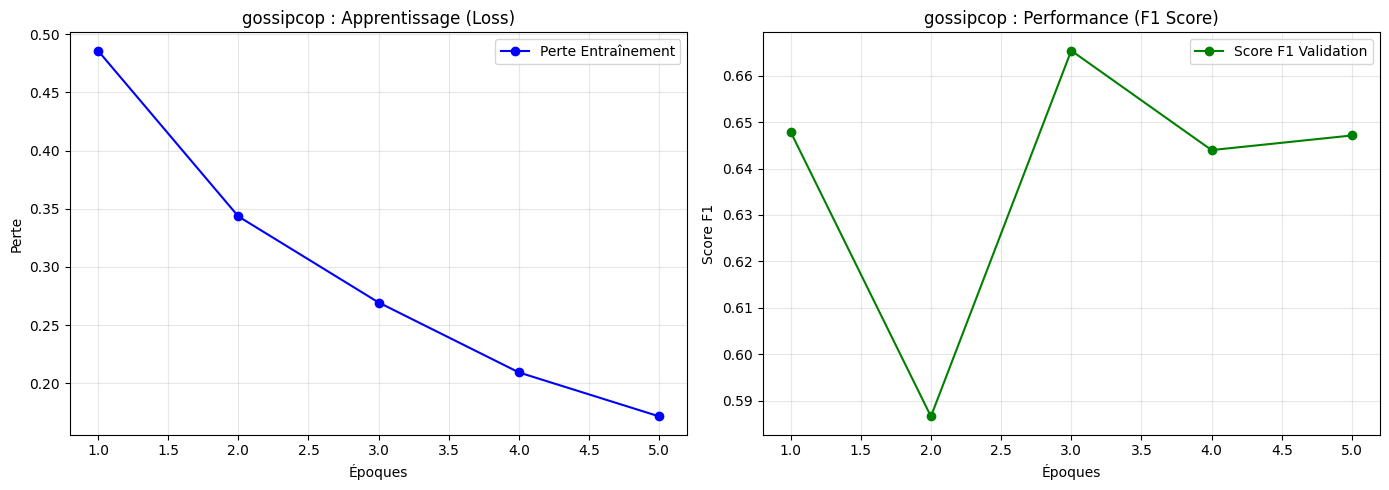


🕵️ [ANALYSE D'ERREURS] Où gossipcop s'est-il trompé ?
   🔴 Texte : "dry goods economist..."
      Réalité : Faux | IA a pensé : Vrai

   🔴 Texte : "game of thrones star sophie turner is engaged to joe jonas..."
      Réalité : Faux | IA a pensé : Vrai

   🔴 Texte : "kris jenner granted 3-year restraining order against joshua jacobs..."
      Réalité : Vrai | IA a pensé : Faux



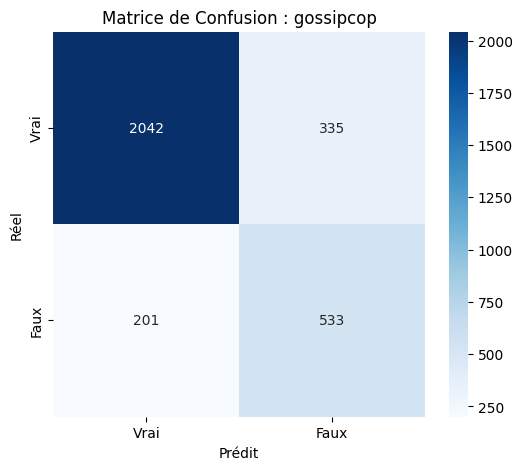


📄 [Rapport : GOSSIPCOP]
              precision    recall  f1-score   support

        Vrai       0.91      0.86      0.88      2377
        Faux       0.61      0.73      0.67       734

    accuracy                           0.83      3111
   macro avg       0.76      0.79      0.77      3111
weighted avg       0.84      0.83      0.83      3111



In [16]:
# ==========================================
# 7. EXÉCUTION PRINCIPALE
# ==========================================
print("\n=== Phase 1 : Chargement des Données ===")
full_df = DataHandler.load_csv_data(ProjectConfig.FILES)
tokenizer = RobertaTokenizer.from_pretrained(ProjectConfig.MODEL_NAME)

# 1. DÉMO PÉDAGOGIQUE
Pedagogie.expliquer_tokenization("Fake news spreads fast.", tokenizer)

results_summary = {}
datasets_to_run = ['politifact', 'gossipcop']

print(f"\n=== Phase 2 : Entraînement ===")

for ds_name in datasets_to_run:
    print(f"\n{'='*60}\nDATASET : {ds_name.upper()}\n{'='*60}")
    
    # Statistiques Visuelles (Pédagogie)
    df_raw = full_df[full_df['dataset_source'] == ds_name]
    DataHandler.afficher_statistiques(df_raw, ds_name)
    Pedagogie.visualiser_distribution(df_raw, ds_name)

    # Préparation
    df_sub = DataHandler.prepare(full_df, ds_name)
    if len(df_sub) < 50: continue

    X_train, X_val, y_train, y_val = train_test_split(
        df_sub['clean_text'].values, df_sub['label'].values, 
        test_size=0.15, stratify=df_sub['label'].values, random_state=42
    )
    
    # Loaders & Model
    train_dl = get_weighted_loader(FastDataset(X_train, y_train, tokenizer, ProjectConfig.MAX_LEN), y_train, ProjectConfig.BATCH_SIZE)
    val_dl = DataLoader(FastDataset(X_val, y_val, tokenizer, ProjectConfig.MAX_LEN), batch_size=ProjectConfig.BATCH_SIZE, num_workers=2)
    
    model = RobertaForSequenceClassification.from_pretrained(ProjectConfig.MODEL_NAME, num_labels=2)
    model.to(device)
    if torch.cuda.device_count() > 1: model = nn.DataParallel(model)
    
    # Entraînement
    trainer = Trainer(model, train_dl, val_dl)
    history, best_f1 = trainer.train()
    results_summary[ds_name] = {'f1': best_f1, 'state': trainer.best_state}
    
    # Visualisation & Analyse Erreurs
    Visualizer.plot_history(history, ds_name)
    
    if hasattr(model, 'module'): model.module.load_state_dict(trainer.best_state)
    else: model.load_state_dict(trainer.best_state)
    
    # Analyse des erreurs (Pédagogie)
    Pedagogie.analyser_erreurs(model, val_dl, tokenizer, device, ds_name)
    
    _, _, y_true, y_pred = trainer.evaluate()
    Visualizer.plot_confusion_matrix(y_true, y_pred, ds_name)
    print(f"\n📄 [Rapport : {ds_name.upper()}]\n{classification_report(y_true, y_pred, target_names=['Vrai', 'Faux'])}")
    
    del model, trainer; torch.cuda.empty_cache()

In [17]:
# ==========================================
# 8. DÉMO INTERACTIVE & SAUVEGARDE
# ==========================================
class InteractiveDemo:
    def __init__(self, state_dict):
        self.model = RobertaForSequenceClassification.from_pretrained(ProjectConfig.MODEL_NAME, num_labels=2)
        self.model.load_state_dict(state_dict)
        self.model.to(device)
        self.model.eval()
        self.tokenizer = RobertaTokenizer.from_pretrained(ProjectConfig.MODEL_NAME)
        print("\n🤖 Le modèle est chargé et prêt à tester vos phrases !")

    def predire(self, texte):
        inputs = self.tokenizer(texte, return_tensors="pt", truncation=True, max_length=128).to(device)
        with torch.no_grad():
            logits = self.model(**inputs).logits
            probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        
        est_fake = np.argmax(probs) == 1
        confiance = probs[1] if est_fake else probs[0]
        
        # Affichage Visuel
        label = "🚨 FAUX (FAKE)" if est_fake else "✅ VRAI (REAL)"
        barre_len = int(confiance * 20)
        barre = "█" * barre_len + "░" * (20 - barre_len)
        couleur = "\033[91m" if est_fake else "\033[92m"
        reset = "\033[0m"
        
        print(f"\n📰 Titre : \"{texte}\"")
        print(f"   Résultat : {couleur}{label}{reset}")
        print(f"   Confiance: [{barre}] {confiance*100:.1f}%")

print("\n" + "="*40 + "\nRÉSUMÉ FINAL ET SAUVEGARDE\n" + "="*40)
if results_summary:
    best_ds = max(results_summary, key=lambda x: results_summary[x]['f1'])
    print(f"🏆 VAINQUEUR : {best_ds.upper()} (F1: {results_summary[best_ds]['f1']:.4f})")

    if not os.path.exists(ProjectConfig.OUTPUT_DIR): os.makedirs(ProjectConfig.OUTPUT_DIR)
    model = RobertaForSequenceClassification.from_pretrained(ProjectConfig.MODEL_NAME, num_labels=2)
    model.load_state_dict(results_summary[best_ds]['state'])
    model.save_pretrained(ProjectConfig.OUTPUT_DIR)
    tokenizer.save_pretrained(ProjectConfig.OUTPUT_DIR)

    print(f"📦 Création de l'archive ZIP...")
    shutil.make_archive(ProjectConfig.ZIP_NAME, 'zip', ProjectConfig.OUTPUT_DIR)
    print(f"✅ Fichier prêt : {ProjectConfig.ZIP_NAME}.zip")

    # DÉMO
    demo = InteractiveDemo(results_summary[best_ds]['state'])
    print("\n      🧪 ZONE DE TEST (Modifiez la liste ci-dessous)")
    tests = [
        "Pope Francis endorses Donald Trump for president.",
        "Scientists confirm the earth is flat.",
        "The economy grew by 2% last quarter."
    ]
    for t in tests: demo.predire(t)
else:
    print("❌ Aucun modèle entraîné.")


RÉSUMÉ FINAL ET SAUVEGARDE
🏆 VAINQUEUR : POLITIFACT (F1: 0.8571)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📦 Création de l'archive ZIP...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Fichier prêt : mon_modele_fake_news.zip

🤖 Le modèle est chargé et prêt à tester vos phrases !

      🧪 ZONE DE TEST (Modifiez la liste ci-dessous)

📰 Titre : "Pope Francis endorses Donald Trump for president."
   Résultat : 🚨 FAUX (FAKE)
   Confiance: [███████████████████░] 95.5%

📰 Titre : "Scientists confirm the earth is flat."
   Résultat : 🚨 FAUX (FAKE)
   Confiance: [████████████████░░░░] 80.9%

📰 Titre : "The economy grew by 2% last quarter."
   Résultat : ✅ VRAI (REAL)
   Confiance: [█████████████░░░░░░░] 67.0%
